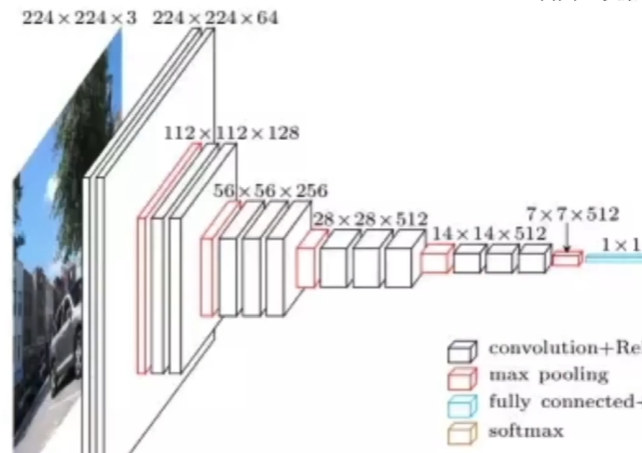使用块的网络:VGG

Alex比Le更深更大, 效果更好; 那么为了效果再好一些, 能不能再深, 再大?
1.更多的全连接层: 太贵
2.更多的卷积层
3.将卷积层组合成块(其实3就是2的实现)
下图:引入VGG块的思想, 将alexnet中的卷积层替换为块, 块中按一定规律排列层, 再将块堆叠

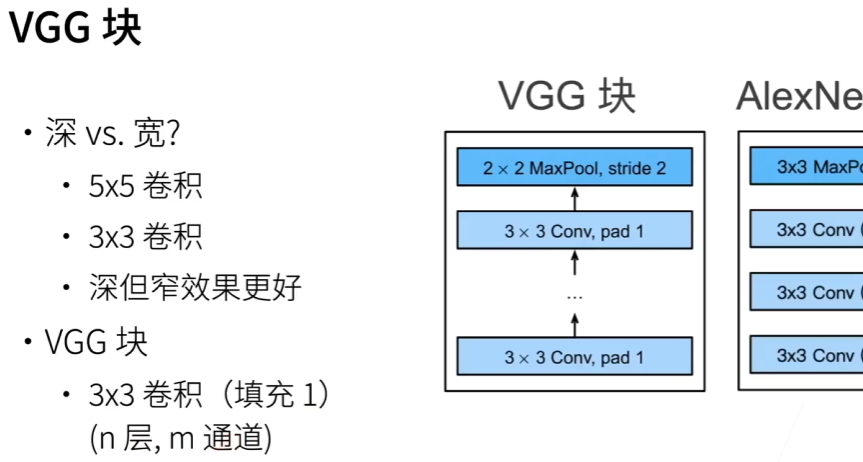

将卷积层组合成块, 然后在层的构建中, 之前的设置卷积层的操作就替换成堆叠VGG块的操作, 不同次数的重复块得到不同的架构
VGG块用规则的模式构成块, 替换了层的直接构建

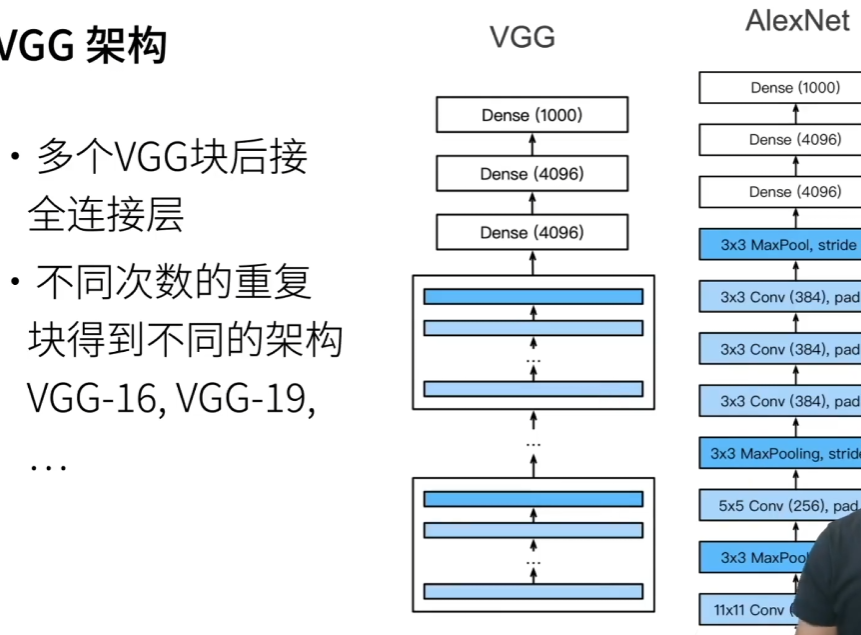

AlexNet:更大更深, ReLu, Dropout,数据增强
VGG: 利用重复块的方式得到更大更深的AlexNet
为何不能直接堆叠单层卷积？
直接增加卷积层会导致以下问题：

​参数爆炸：大尺寸卷积核或无序堆叠会使参数量急剧增长，增加过拟合风险。
​结构混乱：缺乏模块化设计时，各层参数（如卷积核尺寸、通道数）需单独优化，增加调参难度。
​效率低下：未利用小卷积核的级联优势，计算资源利用率较低。
VGG的块设计通过“小卷积核+模块化+规则堆叠”三者的结合，在更深的网络中实现了性能与效率的平衡，成为后续ResNet等现代架构的重要设计范式

In [ ]:
# 代码实现
import torch
from torch import nn
from d2l import torch as d2l

# 传入: 块内卷积层的数量、输入特征图的通道数、输出特征图的通道数
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(
            # 每个卷积层使用3×3卷积核，填充为1（padding=1），保持特征图尺寸不变
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        # 每个卷积层后紧跟ReLU激活函数，引入非线性
        layers.append(nn.ReLU())
        # 第一个卷积层将输入通道数从in_channels转为out_channels，后续卷积层持续out_channels输入输出传递
        in_channels = out_channels
        # 所有卷积层之后添加池化，标志一个VGG块的结束
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

In [ ]:
# 定义VGG的卷积块配置，每个元组(num_convs, out_channels)表示
# 如 (2, 512)表示该块包含2个卷积层，输出512通道
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

def vgg(conv_arch):
    conv_blks = [] # 存储所有卷积块
    in_channels = 1 # 初始输入通道数（假设为灰度图）
    # # 遍历配置，逐块构建网络
    for (num_convs, out_channels) in conv_arch:
         # 添加一个VGG块
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        # 更新下一块的输入通道数为当前块的输出
        in_channels = out_channels

#构造的最终网络： 一些块--展平--全连接层--relu--dropout--全连接层--relu--dropout--线性层
    return nn.Sequential(*conv_blks, nn.Flatten(),
                         nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(),
                         nn.Dropout(0.5), nn.Linear(4096, 4096), nn.ReLU(),
                         nn.Dropout(0.5), nn.Linear(4096, 10))

net = vgg(conv_arch)

In [ ]:
# 查看每一层
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])

In [ ]:
#  实操
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

NiN(网络中的网络)
卷积层需要较少的参数，但是卷积层之后的第一个全连接层会有很多参数
解决方法： NiN块
一个NiN块： 一个卷积层--（1×1的卷积层）全连接层--（1×1的卷积层）全连接层
步幅1，无填充，输出形状跟卷积层输出一样；起到了全连接层的作用

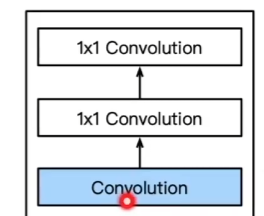

·NiN块使用卷积层加两个1x1卷积层，
·后者对每个像素增加了非线性性
·NiN使用全局平均池化层来替代VGG和AlexNet中的全连接层
·不容易过拟合，更少的参数个数